In [1]:
import sys
sys.path.append("../src/")

import pandas as pd
import numpy as np
from scipy.stats import mstats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer

from stats import CalculateStats
from bivariate import BivariateAnalysis

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# pd.options.display.float_format = '{:,.1%}'.format

In [2]:
# Import data
relative_path = '../data/pd_data_pipeline.xlsx'
df = pd.read_excel(relative_path, engine='openpyxl')

df.head()

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,num_bankrupt,num_iva,min_months_since_bankrupt,pl_flag,region,ltv,arrears_months,origination_date,maturity_date,repayment_type,arrears_status,arrears_segment,mob,remaining_mat,loan_term,live_status,repaid_status,month,arrears_event,bankrupt_event,term_expiry_event,worst_arrears_status,max_arrears_12m,recent_arrears_date,months_since_2mia,avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,r_a,0.7586,0.00000,2005-09-14,2040-09-30,Non-IO,1,1,120,300,35,1,0,9,0,0,0,1,0.00000,NaT,NaN,0.0,-42.0,0.0,132080.0,542.0,0.4578,76749,3,11
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,r_b,0.6973,0.00000,2006-01-20,2031-01-31,Non-IO,1,1,116,184,25,1,0,9,0,0,0,1,0.00000,NaT,NaN,0.0,0.0,0.0,116972.0,494.0,0.6299,78451,10,7
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,0.0,0.0,0.0,0,r_c,0.6959,2.18823,2004-12-21,2029-12-31,Non-IO,2,2,129,171,25,1,0,9,1,0,0,2,2.18823,2015-09-30,0.0,0.0,1198.0,2.0,128500.0,290.0,0.6331,31038,3,6
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,r_d,0.1099,0.00000,2005-06-21,2023-06-30,Non-IO,1,1,123,93,18,1,0,9,0,0,0,1,0.00000,NaT,NaN,0.0,-114.0,0.0,36610.0,460.0,0.4990,56663,8,6
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,r_e,0.3776,0.00000,2006-07-19,2041-07-31,Non-IO,1,1,110,310,35,1,0,9,0,0,0,1,0.00000,NaT,NaN,0.0,0.0,0.0,77518.0,468.0,0.9568,77014,10,3


In [3]:
import pandas as pd
import numpy as np
from optbinning import OptimalBinning
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

# Load the breast cancer dataset and add some random noise
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer(as_frame=True)
X, y = data['data'], data['target']
X = X.assign(random1=np.random.rand(len(X)), random2=np.random.randn(len(X)))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Custom transformer to calculate IV and select top features
class SelectByIV(BaseEstimator, TransformerMixin):
    def __init__(self, n_top_features=3):
        self.n_top_features = n_top_features
        self.top_cols = None

    def fit(self, X, y):
        iv_dict = {}
        for col in X.columns:
            optb = OptimalBinning(name=col, dtype="numerical", solver="cp")
            optb.fit(X[col], y)
            binning_table = optb.binning_table.build()
            iv_dict[col] = binning_table.loc['Totals', 'IV']
        self.top_cols = sorted(iv_dict, key=iv_dict.get, reverse=True)[:self.n_top_features]
        return self

    def transform(self, X):
        return X[self.top_cols]

# Create pipeline
pipeline = Pipeline([
    ('select_by_iv', SelectByIV(n_top_features=3)),
    ('classifier', XGBClassifier(eval_metric='logloss'))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions and evaluate
from sklearn.metrics import accuracy_score

y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 94.74%


In [4]:
# Extract the XGBoost model
xgb_model = pipeline.named_steps['classifier']

In [7]:
xgb_model.feature_names_in_

array(['worst radius', 'worst area', 'worst concave points'], dtype='<U20')

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

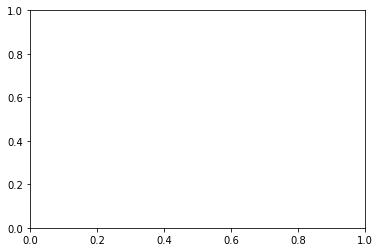

In [5]:
import xgboost as xgb
xgb.plot_tree(xgb_model)

In [ ]:
!pip install graphviz

In [ ]:
from optbinning import OptimalBinning
import pandas as pd

# Sample DataFrame
df = pd.DataFrame({
    'age': [25, 45, 35, 50, 23],
    'default': [0, 1, 0, 1, 0]
})

optb = OptimalBinning(name='age', dtype="numerical", solver="cp")
optb.fit(df['age'], df['default'])

In [ ]:
optb.binning_table.build()

In [ ]:
optb.status

In [ ]:
optb.verbose

In [ ]:
optb.information()

In [ ]:
binning_table = optb.binning_table.build()
iv = binning_table.loc['Totals', 'IV']

In [ ]:
type(binning_table.loc['Totals', 'IV'])

In [ ]:
binning_table.loc['Totals', 'IV']

In [ ]:
# Define a column transformer
preprocessor = ColumnTransformer(
    transformers=[('num', CalculateStats(), df.columns)],
    remainder='passthrough'
)

bivariate = ColumnTransformer(
    transformers=[('num2', BivariateAnalysis(), ['loan_balance', 'ltv', 'worst_arrears_status', 'annual_income'])],
    remainder='passthrough'
)

# Create pipeline and transform the data
y = df['pl_flag']

pipeline = Pipeline(steps=[
                # ('preprocessor', preprocessor),
                ('bivariate_analysis', bivariate)
                          ])
pipeline.fit(y)

# Access the statistics DataFrame
stats_df = pipeline.named_steps['preprocessor'].named_transformers_['num'].stats_df
# gini_df = pipeline.named_steps['bivariate'].named_transformers_['num2'].gini_df

# Display the first few rows of the statistics DataFrame
stats_df.head(30)

In [ ]:
xxx

In [ ]:
# Define a column transformer
preprocessor = ColumnTransformer(
    transformers=[('num', CalculateStats(), df.columns)],
    remainder='passthrough'
)

# Create pipeline and transform the data
y = df['pl_flag']

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('bivariate_analysis', BivariateAnalysis(cols=['loan_balance', 'ltv', 'worst_arrears_status', 'annual_income']))

                          ])
pipeline.fit_transform(df, y)

# Access the statistics DataFrame
stats_df = pipeline.named_steps['preprocessor'].named_transformers_['num'].stats_df
gini_df = pipeline.named_steps['preprocessor'].named_transformers_['num'].stats_df

# Display the first few rows of the statistics DataFrame
stats_df.head(30)

In [ ]:
xxxx

In [ ]:




# Custom Transformer for Segmentation
class CustomSegmenter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.segments = pd.qcut(X['Feature1'], 4, labels=False).unique()
        return self

    def transform(self, X, y=None):
        X['Segment'] = pd.qcut(X['Feature1'], 4, labels=self.segments)
        return X

# Custom Transformer for Bivariate Analysis
class BivariateAnalysis(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.segment_gini_df = pd.DataFrame()

    def fit(self, X, y):
        ginis = []
        for segment in self.segments:
            segment_data = X[X['Segment'] == segment]
            segment_y = y.loc[segment_data.index]
            gini_coefficient = gini(segment_y)
            ginis.append({'Segment': segment, 'Gini': gini_coefficient})
        self.segment_gini_df = pd.DataFrame(ginis)
        print("Calculated segment-specific Gini coefficients")
        print(self.segment_gini_df)
        return self

    def transform(self, X):
        return X  # No changes to data

# Custom Transformer for Segmented Preprocessing
class CustomSegmentedPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.segment_params = {}

    def fit(self, X, y=None):
        for segment in self.segments:
            segment_data = X[X['Segment'] == segment].drop('Segment', axis=1)

            # Winsorization
            winsorized = mstats.winsorize(segment_data, limits=0.05)

            # Mean Imputation
            imputer = SimpleImputer(strategy='mean')
            imputed = imputer.fit_transform(winsorized)

            # Scaling
            scaler = StandardScaler()
            scaler.fit(imputed)

            self.segment_params[segment] = {'imputer': imputer, 'scaler': scaler}
        return self

    def transform(self, X):
        transformed_data = []
        for segment in self.segments:
            segment_data = X[X['Segment'] == segment]
            if segment_data.empty:
                continue

            imputer = self.segment_params[segment]['imputer']
            scaler = self.segment_params[segment]['scaler']

            segment_data = segment_data.drop('Segment', axis=1)

            # Apply Winsorization, Imputation, and Scaling
            segment_data = mstats.winsorize(segment_data, limits=0.05)
            segment_data = imputer.transform(segment_data)
            segment_data = scaler.transform(segment_data)

            transformed_data.append(pd.DataFrame(segment_data, columns=['Feature1', 'Feature2']))

        return pd.concat(transformed_data).sort_index()

# Create synthetic data
np.random.seed(0)
data = {'Feature1': np.random.rand(100),
        'Feature2': np.random.rand(100),
        'Target': np.random.choice([True, False], 100)}
df = pd.DataFrame(data)

# Split the data
X = df[['Feature1', 'Feature2']]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize classes
segmenter = CustomSegmenter()
bivariate_analyzer = BivariateAnalysis()
segmented_preprocessor = CustomSegmentedPreprocessor()

# Set the shared segment list
segmenter.fit(X_train)
bivariate_analyzer.segments = segmenter.segments
segmented_preprocessor.segments = segmenter.segments

# Build Pipeline
pipeline = Pipeline([
    ('segmenter', segmenter),
    ('bivariate_analysis', bivariate_analyzer),
    ('segmented_preprocessor', segmented_preprocessor),
    ('classifier', LogisticRegression()),
    ('calibrator', CalibratedClassifierCV(base_estimator=LogisticRegression(), method='sigmoid'))
])

# Fit the Pipeline
pipeline.fit(X_train, y_train)

# Make Predictions
y_pred = pipeline.predict(X_test)

# Evaluate Model
print('Accuracy:', accuracy_score(y_test, y_pred))